In [35]:
import sage_data_client
import matplotlib.pyplot as plt
import pandas as pd
from metpy.calc import dewpoint_from_relative_humidity, wet_bulb_temperature
from metpy.units import units
from PIL import Image
import numpy as np
import datetime

from matplotlib.dates import DateFormatter

In [36]:
hours = 72
end = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
start = (datetime.datetime.utcnow() -  \
                        datetime.timedelta(hours=hours)).strftime('%Y-%m-%dT%H:%M:%SZ')

#start = "2023-05-05T18:00:00Z"
#end = "2023-05-06T12:00:00Z"


In [37]:
# Query the SAGE data client to access the data; use 'name' filter
#this takes a LONG time when doing more than a day

df_temp = sage_data_client.query(start=start,
                                 end=end, 
                                    filter={
                                        "name" : 'wxt.env.temp|wxt.env.humidity|wxt.env.pressure|wxt.rain.accumulation',
                                        "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.23.5.*",
                                        "vsn" : "W08D",
                                        "sensor" : "vaisala-wxt536"
                                    }
)

In [38]:
# Query the SAGE data client to access the data; use 'name' filter
#this takes a LONG time when doing more than a day

winds = sage_data_client.query(start=start,
                                 end=end, 
                                    filter={
                                        "name" : 'wxt.wind.speed|wxt.wind.direction',
                                        "plugin" : "registry.sagecontinuum.org/jrobrien/waggle-wxt536:0.23.5.*",
                                        "vsn" : "W08D",
                                        "sensor" : "vaisala-wxt536"
                                    }
)


In [39]:
hums = df_temp[df_temp['name']=='wxt.env.humidity']
temps = df_temp[df_temp['name']=='wxt.env.temp']
pres = df_temp[df_temp['name']=='wxt.env.pressure']
rain = df_temp[df_temp['name']=='wxt.rain.accumulation']


npres = len(pres)
nhum = len(hums)
ntemps = len(temps)
nrains = len(rain)
print(npres, nhum, ntemps, nrains)
minsamps = min([nhum, ntemps, npres, nrains])

vals = temps.set_index('timestamp')[0:minsamps]
vals['temperatures'] = vals.value.to_numpy()[0:minsamps]
vals['humidity'] = hums.value.to_numpy()[0:minsamps]
vals['pressure'] = pres.value.to_numpy()[0:minsamps]
vals['rainfall'] = rain.value.to_numpy()[0:minsamps]



2366027 2366028 2366028 2366026


In [40]:
direction = winds[winds['name']=='wxt.wind.direction']
speed = winds[winds['name']=='wxt.wind.speed']

nspeed = len(speed)
ndir = len(direction)
print(nspeed, ndir)
minsamps = min([nspeed, ndir])

windy = speed.set_index('timestamp')[0:minsamps]
windy['speed'] = windy.value.to_numpy()[0:minsamps]
windy['direction'] = direction.value.to_numpy()[0:minsamps]


winds10mean = windy.resample('60S').mean(numeric_only=True).ffill()
winds10max = windy.resample('60S').max(numeric_only=True).ffill()

2366028 2366028


In [41]:
dp = dewpoint_from_relative_humidity( vals.temperatures.to_numpy() * units.degC, 
                                     vals.humidity.to_numpy() * units.percent)

vals['dewpoint'] = dp

In [42]:
#vals10 = vals.fillna('nearest').resample('10S').mean(numeric_only=True)
vals10 = vals.resample('10S').mean(numeric_only=True).ffill() #ffil gets rid of nans due to empty resample periods

#vals10['pydatetime'] = vals10.index.to_pydatetime()
#vals10 = vals10.set_index('pydatetime')

In [43]:
vals10

,value,temperatures,humidity,pressure,rainfall,dewpoint
timestamp,,,,,,
2023-05-06 12:10:00+00:00,14.7,14.7,62.600000,995.600000,0.34,7.640738
2023-05-06 12:10:10+00:00,14.7,14.7,62.600000,995.600000,0.34,7.640738
2023-05-06 12:10:20+00:00,14.7,14.7,62.600000,995.600000,0.34,7.640738
2023-05-06 12:10:30+00:00,14.7,14.7,62.600000,995.600000,0.34,7.640738
2023-05-06 12:10:40+00:00,14.7,14.7,62.600000,995.600000,0.34,7.640738
...,...,...,...,...,...,...
2023-05-09 11:39:20+00:00,9.0,9.0,95.600000,996.700000,6.73,8.334989
2023-05-09 11:39:30+00:00,9.0,9.0,95.570588,996.730252,6.73,8.330452
2023-05-09 11:39:40+00:00,9.0,9.0,95.500000,996.800000,6.73,8.319563


In [44]:
wb = wet_bulb_temperature(vals10.pressure.to_numpy() * units.hPa,
                          vals10.temperatures.to_numpy() * units.degC,
                          vals10.dewpoint.to_numpy() * units.degC)

vals10['wetbulb'] = wb

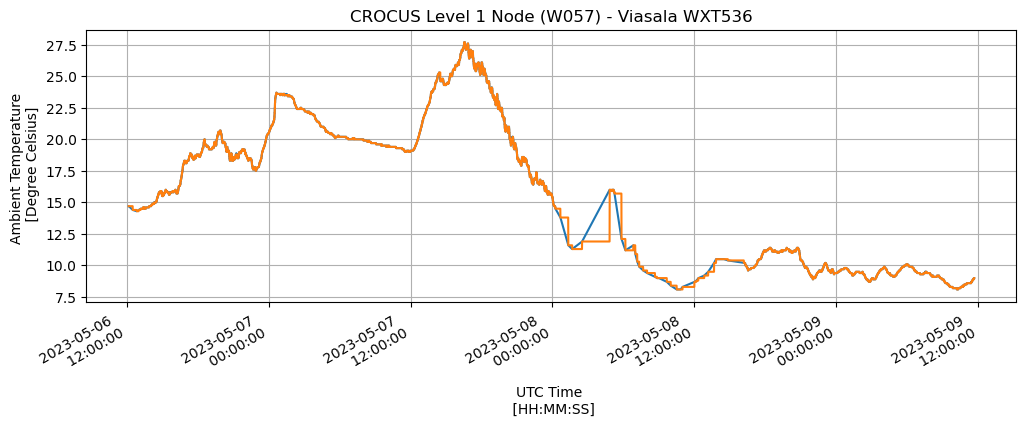

In [45]:
fig, axs = plt.subplots(figsize=(12, 4))

# Define Format of how the date is displayed
date_form = DateFormatter("%Y-%m-%d \n %H:%M:%S")

# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Viasala WXT536',
                                          ax=axs
                                          )

vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Viasala WXT536',
                                          ax=axs
                                          )


axs.xaxis.set_major_formatter(date_form)
axs.grid(True)

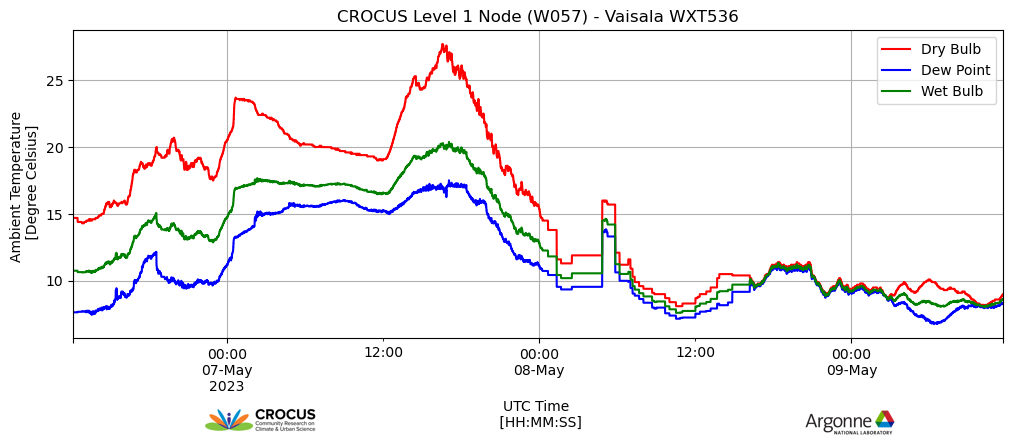

In [46]:
fig, axs = plt.subplots(figsize=(12, 4))

# Define Format of how the date is displayed
date_form = DateFormatter("%Y-%m-%d \n %H:%M")

# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='r', label='Dry Bulb'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='b', label='Dew Point'
                                          )


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='g', label='Wet Bulb'
                                          )


#axs.xaxis.set_major_formatter(date_form)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)

plt.legend()
axs.grid(True)

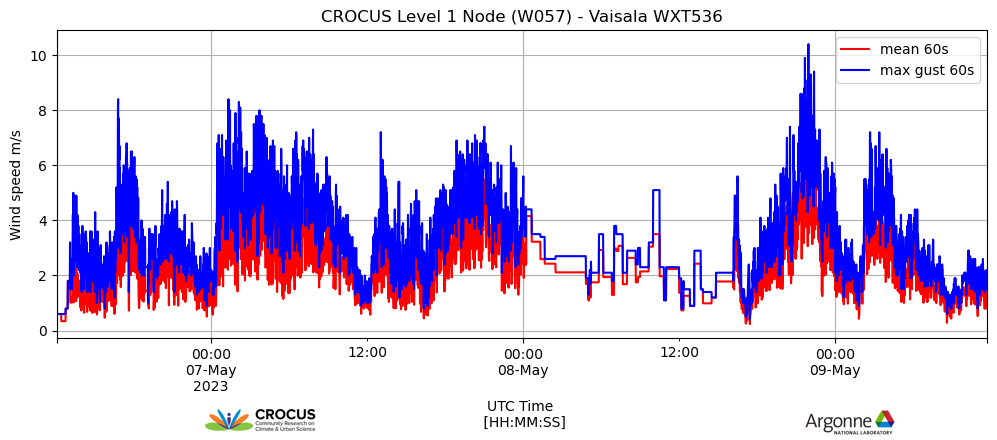

In [47]:
fig, axs = plt.subplots(figsize=(12, 4))

# Define Format of how the date is displayed
date_form = DateFormatter("%Y-%m-%d \n %H:%M")

# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='CROCUS Level 1 Node (W057) - Vaisala WXT536',
                                          ax=axs, color='b', label='max gust 60s'
                                          )



#axs.xaxis.set_major_formatter(date_form)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)

plt.legend()
axs.grid(True)

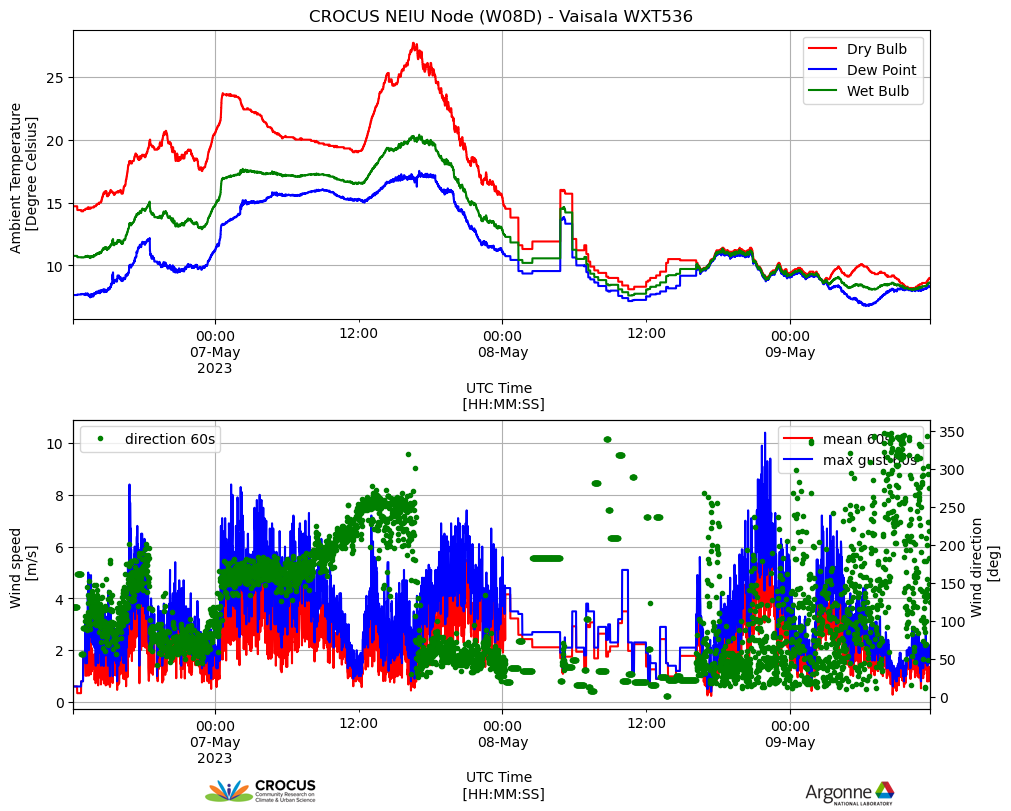

In [48]:
fig, axs = plt.subplots( ncols=1, nrows=2, figsize=[10,8], constrained_layout=True)
vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          color='g', label='Wet Bulb',
                                          ax=axs[0])

axs[0].legend()
axs[0].grid(True)

winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='',
                                          ax=axs[1], color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed \n [m/s]',
                                          title='',
                                          ax=axs[1], color='b', label='max gust 60s'
                                          )
axs[1].legend()
axs[1].grid(True)

ytwin = plt.twinx()

winds10mean.direction.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind direction \n [deg]',
                                          title='',
                                          ax=ytwin, color='g', label='direction 60s',
                                          marker='.', linestyle='none')

ytwin.legend(loc=2)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)


In [49]:
#hours = 19
#end = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
#start = (datetime.datetime.utcnow() -  \
#                        datetime.timedelta(hours=hours)).strftime('%Y-%m-%dT%H:%M:%SZ')

df_aq = sage_data_client.query(
    start=start,
    end=end, 
    filter={
        "plugin": "registry.sagecontinuum.org/jrobrien/waggle-aqt:0.23.5.04.*",
        "vsn": "W08D"
    }
)

pm25 = df_aq[df_aq['name']=='aqt.particle.pm2.5']
pm10 = df_aq[df_aq['name']=='aqt.particle.pm1']
pm100 = df_aq[df_aq['name']=='aqt.particle.pm10']

no = df_aq[df_aq['name']=='aqt.gas.no']
o3 = df_aq[df_aq['name']=='aqt.gas.ozone']
no2 = df_aq[df_aq['name']=='aqt.gas.no2']
co = df_aq[df_aq['name']=='aqt.gas.co']
aqtemp = df_aq[df_aq['name']=='aqt.env.temp']
aqhum = df_aq[df_aq['name']=='aqt.env.humidity']


aqvals = pm25.set_index('timestamp')
aqvals['pm2.5'] = aqvals.value.to_numpy().astype(float)
aqvals['pm1.0'] = pm10.value.to_numpy().astype(float)
aqvals['pm10.0'] = pm100.value.to_numpy().astype(float)

aqvals['no'] = no.value.to_numpy().astype(float)
aqvals['o3'] = o3.value.to_numpy().astype(float)
aqvals['no2'] = no2.value.to_numpy().astype(float)
aqvals['co'] = co.value.to_numpy().astype(float)
aqvals['temp'] =  aqtemp.value.to_numpy().astype(float)
aqvals['hum'] =  aqhum.value.to_numpy().astype(float)


dp = dewpoint_from_relative_humidity( aqvals.temp.to_numpy() * units.degC, 
                                     aqvals.hum.to_numpy() * units.percent)

aqvals['dewpoint'] = dp


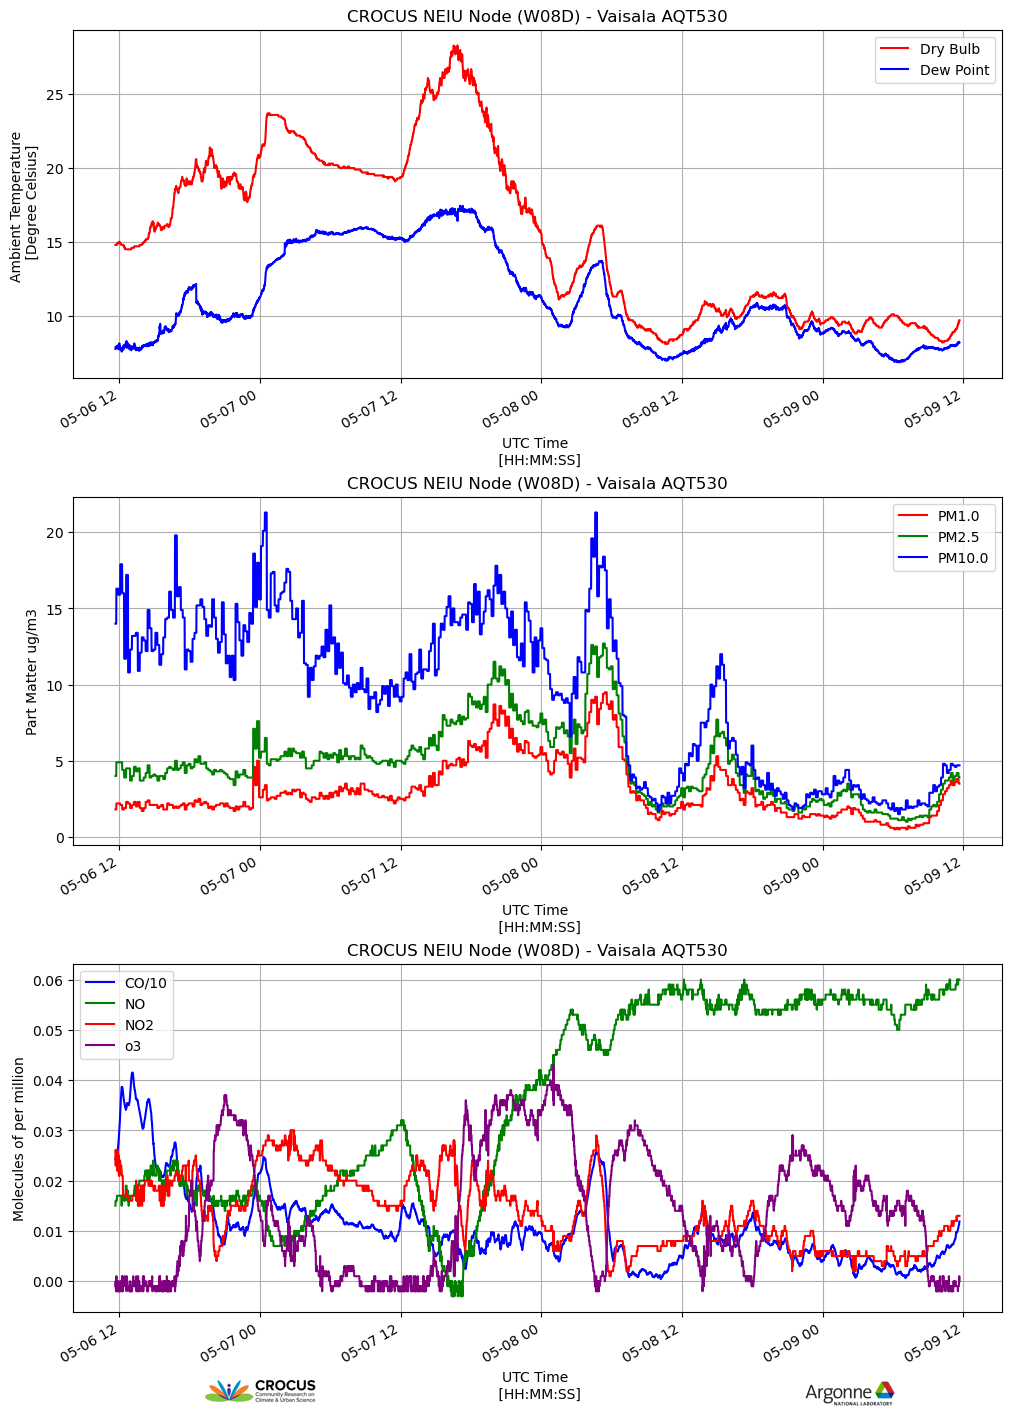

In [50]:

fig, axs = plt.subplots( ncols=1, nrows=3, figsize=[10,14], constrained_layout=True)
aqvals.temp.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )

aqvals.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


axs[0].legend()
axs[0].grid(True)


aqvals['pm1.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[1], color='r', label='PM1.0',
                                          )

aqvals['pm2.5'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[1], color='g', label='PM2.5',
                                          )

aqvals['pm10.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[1], color='b', label='PM10.0',
                                          )

axs[1].legend()
axs[1].grid(True)


(aqvals['co']/10.0).plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='b', label='CO/10',
                                          )

aqvals['no'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='g', label='NO',
                                          )


aqvals['no2'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='r', label='NO2',
                                          )


aqvals['o3'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[2], color='purple', label='o3',
                                          )

axs[2].legend()
axs[2].grid(True)

im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)


(19483.486168981482, 19486.486168981482)

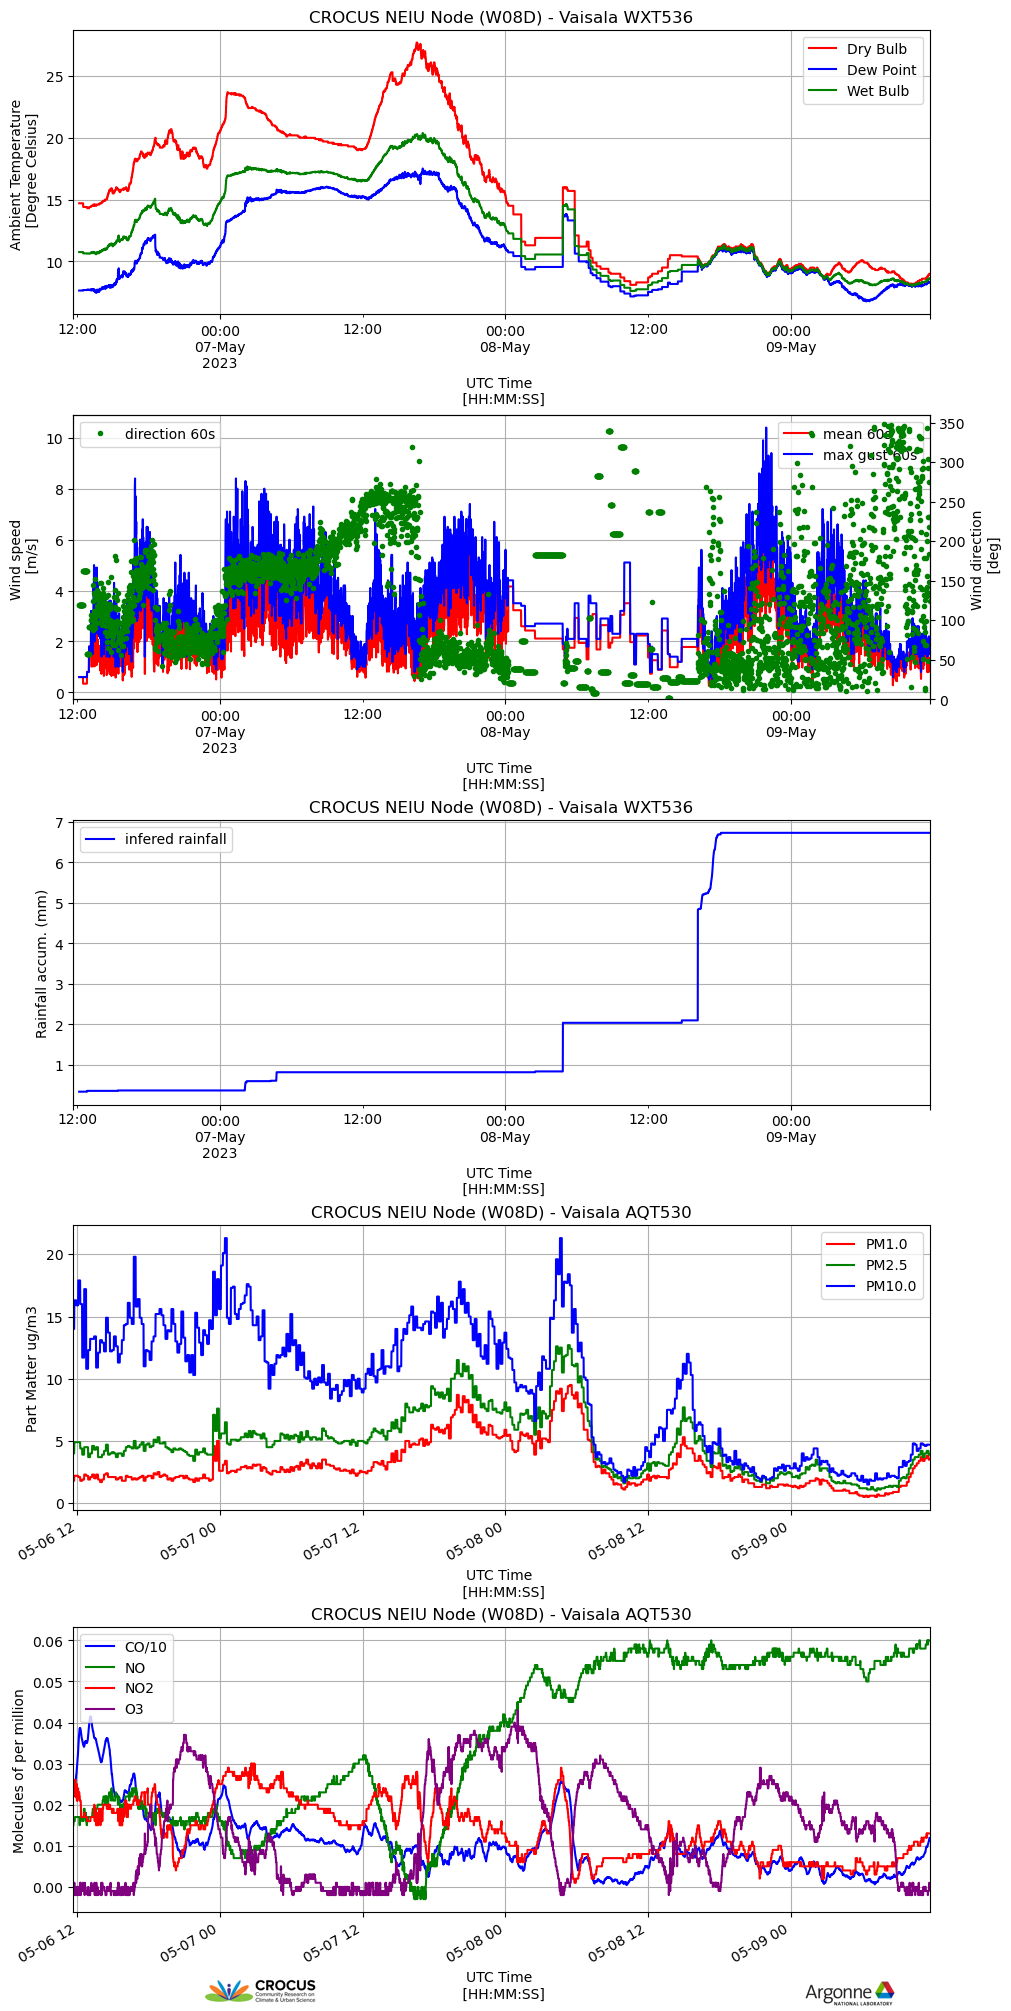

In [51]:
fig, axs = plt.subplots( ncols=1, nrows=5, figsize=[10,20], constrained_layout=True)

vals10.temperatures.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          ax=axs[0], color='r', label='Dry Bulb',
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
vals10.dewpoint.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                           color='b', label='Dew Point',
                                          ax=axs[0])


vals10.wetbulb.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Ambient Temperature \n [Degree Celsius]',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          color='g', label='Wet Bulb',
                                          ax=axs[0])

axs[0].legend()
axs[0].grid(True)

winds10mean.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed m/s',
                                          title='',
                                          ax=axs[1], color='r', label='mean 60s'
                                          )


# Note: Use the Pandas DataFrame 'loc' functionality to search the object for the ambient temp
winds10max.speed.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind speed \n [m/s]',
                                          title='',
                                          ax=axs[1], color='b', label='max gust 60s'
                                          )
axs[1].legend()
axs[1].grid(True)

ytwin = plt.twinx(ax=axs[1])

winds10mean.direction.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Wind direction \n [deg]',
                                          title='',
                                          ax=ytwin, color='g', label='direction 60s',
                                          marker='.', linestyle='none')

ytwin.legend(loc=2)
ytwin.set_ylim([0,360])
im = Image.open('Argonnelablogo.PNG')

im.thumbnail([im.size[0]/12, im.size[1]/12])
height = im.size[1]
width = im.size[0]
fig.figimage(im, 800  , 0)

im2 = Image.open('cr.png')

im2.thumbnail([im2.size[0]/4, im2.size[1]/4])
height = im2.size[1]
width = im2.size[0]
fig.figimage(im2, 200  , -20, zorder=-1)
#axs.xaxis.set_major_formatter(date_form)

vals10.rainfall.plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Rainfall accum. (mm)',
                                          title='CROCUS NEIU Node (W08D) - Vaisala WXT536',
                                          ax=axs[2], color='b', label='infered rainfall',
                                          )

axs[2].legend()
axs[2].grid(True)


aqvals['pm1.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[3], color='r', label='PM1.0',
                                          )

aqvals['pm2.5'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[3], color='g', label='PM2.5',
                                          )

aqvals['pm10.0'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Part Matter ug/m3',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[3], color='b', label='PM10.0',
                                          )

axs[3].legend()
axs[3].grid(True)


(aqvals['co']/10.0).plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='b', label='CO/10',
                                          )

aqvals['no'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='g', label='NO',
                                          )


aqvals['no2'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='r', label='NO2',
                                          )


aqvals['o3'].plot(xlabel='UTC Time \n [HH:MM:SS]',
                                          ylabel='Molecules of per million',
                                          title='CROCUS NEIU Node (W08D) - Vaisala AQT530',
                                          ax=axs[4], color='purple', label='O3',
                                          )

axs[4].legend()
axs[4].grid(True)

axs[0].set_xlim([start,end])
axs[1].set_xlim([start,end])
axs[2].set_xlim([start,end])
axs[3].set_xlim([start,end])
axs[4].set_xlim([start,end])
